In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from itertools import product
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [9]:
#df = pd.read_pickle('data/WB_statistics.pkl')
df = pd.read_pickle('data/all_data.pkl')

In [10]:
df_deaths = df[df['indice'] == 'Number of deaths']
df_births = df[df['indice'] == 'Number of births']

df_deaths.loc[:, 'date'] = pd.to_datetime(df_deaths['date'])
df_births.loc[:, 'date'] = pd.to_datetime(df_births['date'])

# Set 'date' as the index of your dataframe
df_deaths.set_index('date', inplace=True)
df_births.set_index('date', inplace=True)

In [11]:
def optimize_SARIMA(parameters_list, seasonal_parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in parameters_list:
        for seasonal_param in seasonal_parameters_list:
            try:
                model = SARIMAX(exog, order=(param[0], d, param[1]), 
                                seasonal_order=(seasonal_param[0], D, seasonal_param[1], s)).fit(disp=-1)
            except:
                continue
                
            aic = model.aic
            results.append([param, seasonal_param, model.aic])
            
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', '(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

p = range(0, 2, 1)
d = 1
q = range(0, 2, 1)
P = range(0, 3, 1)
D = 1
Q = range(0, 3, 1)
s = 12
parameters = product(p, q)
parameters_list = list(parameters)
seasonal_parameters = product(P, Q)
seasonal_parameters_list = list(seasonal_parameters)

result_df_deaths = optimize_SARIMA(parameters_list, seasonal_parameters_list, 1, 1, s, df_deaths['value'])
result_df_births = optimize_SARIMA(parameters_list, seasonal_parameters_list, 1, 1, s, df_births['value'])


In [12]:
best_model_parameters_deaths = result_df_deaths.iloc[0, 0]
best_seasonal_parameters_deaths = result_df_deaths.iloc[0, 1]
best_model_parameters_births = result_df_births.iloc[0, 0]
best_seasonal_parameters_births = result_df_births.iloc[0, 1]

print(f'Best model parameters for deaths: {best_model_parameters_deaths} and {best_seasonal_parameters_deaths}')
print(f'Best model parameters for births: {best_model_parameters_births} and {best_seasonal_parameters_births}')


Best model parameters for deaths: (1, 1) and (2, 1)
Best model parameters for births: (0, 1) and (2, 2)


In [13]:
# Split the data
train_deaths = df_deaths.iloc[:df_deaths.shape[0]*75//100]['value']
test_deaths = df_deaths.iloc[df_deaths.shape[0]*75//100:]['value']

train_births = df_births.iloc[:df_births.shape[0]*75//100]['value']
test_births = df_births.iloc[df_births.shape[0]*75//100:]['value']

In [14]:
# Fit the SARIMA model with the best parameters
model_deaths = SARIMAX(train_deaths, order=(best_model_parameters_deaths[0], d, best_model_parameters_deaths[1]), 
                       seasonal_order=(best_seasonal_parameters_deaths[0], D, best_seasonal_parameters_deaths[1], s))
model_deaths_fit = model_deaths.fit(disp=0)

model_births = SARIMAX(train_births, order=(best_model_parameters_births[0], d, best_model_parameters_births[1]), 
                       seasonal_order=(best_seasonal_parameters_births[0], D, best_seasonal_parameters_births[1], s))
model_births_fit = model_births.fit(disp=0)

# Prediction
forecast_deaths = model_deaths_fit.forecast(steps=len(test_deaths))
forecast_births = model_births_fit.forecast(steps=len(test_births))

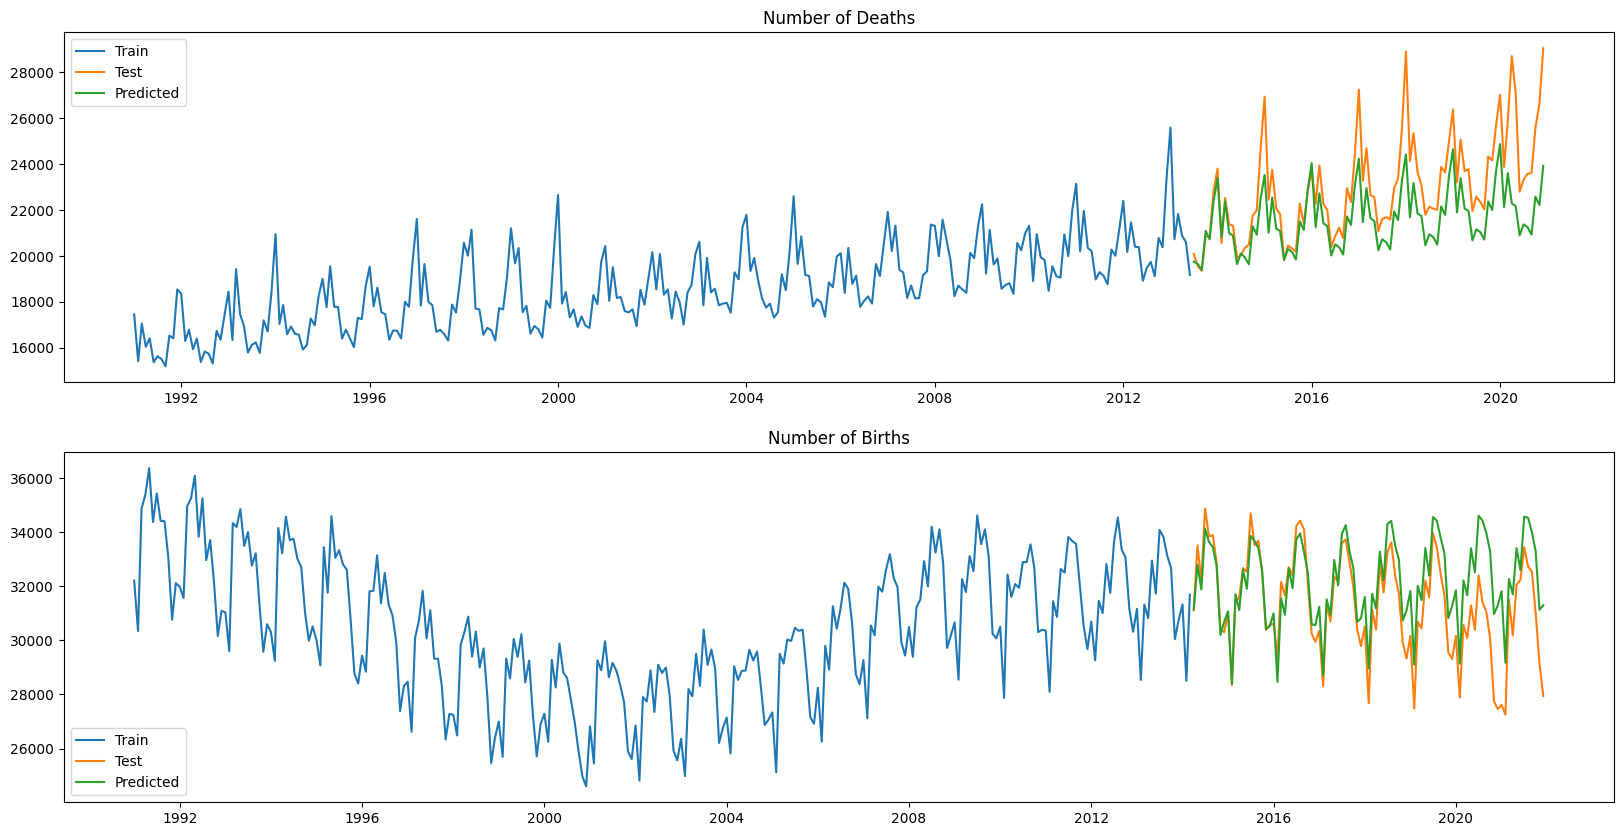

In [15]:
# Plot actual vs predicted
fig, axs = plt.subplots(2, figsize=(20,10))

# plot for deaths
axs[0].plot(train_deaths, label='Train')
axs[0].plot(test_deaths, label='Test')
axs[0].plot(forecast_deaths, label='Predicted')
axs[0].legend(loc='best')
axs[0].set_title('Number of Deaths')

# plot for births
axs[1].plot(train_births, label='Train')
axs[1].plot(test_births, label='Test')
axs[1].plot(forecast_births, label='Predicted')
axs[1].legend(loc='best')
axs[1].set_title('Number of Births')

plt.show()

In [16]:
# Naive prediction: repeat the last 12 months
naive_deaths = np.resize(train_deaths[-12:].values, len(test_deaths))
naive_births = np.resize(train_births[-12:].values, len(test_births))

# Calculate MSE for SARIMA predictions
mse_sarima_deaths = mean_squared_error(test_deaths, forecast_deaths)
mse_sarima_births = mean_squared_error(test_births, forecast_births)

# Calculate MSE for naive predictions
mse_naive_deaths = mean_squared_error(test_deaths, naive_deaths)
mse_naive_births = mean_squared_error(test_births, naive_births)

print(f'MSE for SARIMA predictions (deaths): {mse_sarima_deaths}')
print(f'MSE for naive predictions (deaths): {mse_naive_deaths}')
print(f'MSE for SARIMA predictions (births): {mse_sarima_births}')
print(f'MSE for naive predictions (births): {mse_naive_births}')

MSE for SARIMA predictions (deaths): 3377292.9231016906
MSE for naive predictions (deaths): 6834592.744444445
MSE for SARIMA predictions (births): 1875565.8529522375
MSE for naive predictions (births): 1093490.7634408602


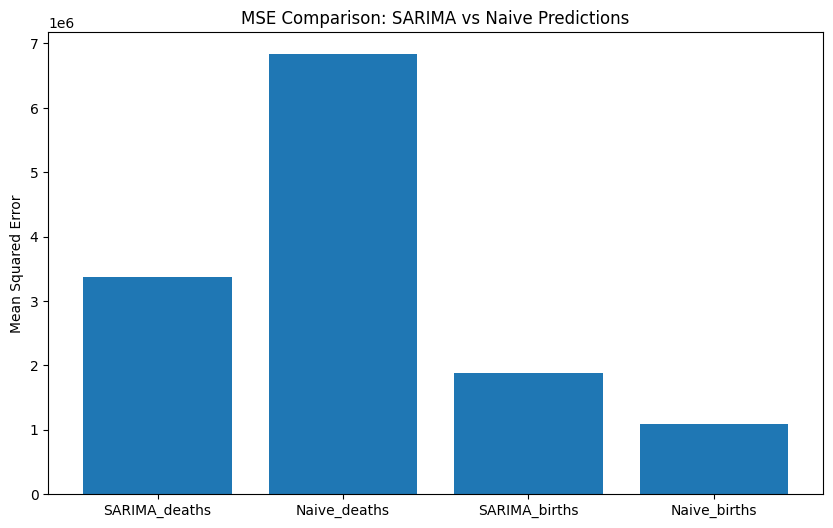

In [17]:
mse_values = [mse_sarima_deaths, mse_naive_deaths, mse_sarima_births, mse_naive_births]
labels = ['SARIMA_deaths', 'Naive_deaths', 'SARIMA_births', 'Naive_births']

plt.figure(figsize=(10, 6))
plt.bar(labels, mse_values)
plt.ylabel('Mean Squared Error')
plt.title('MSE Comparison: SARIMA vs Naive Predictions')
plt.show()

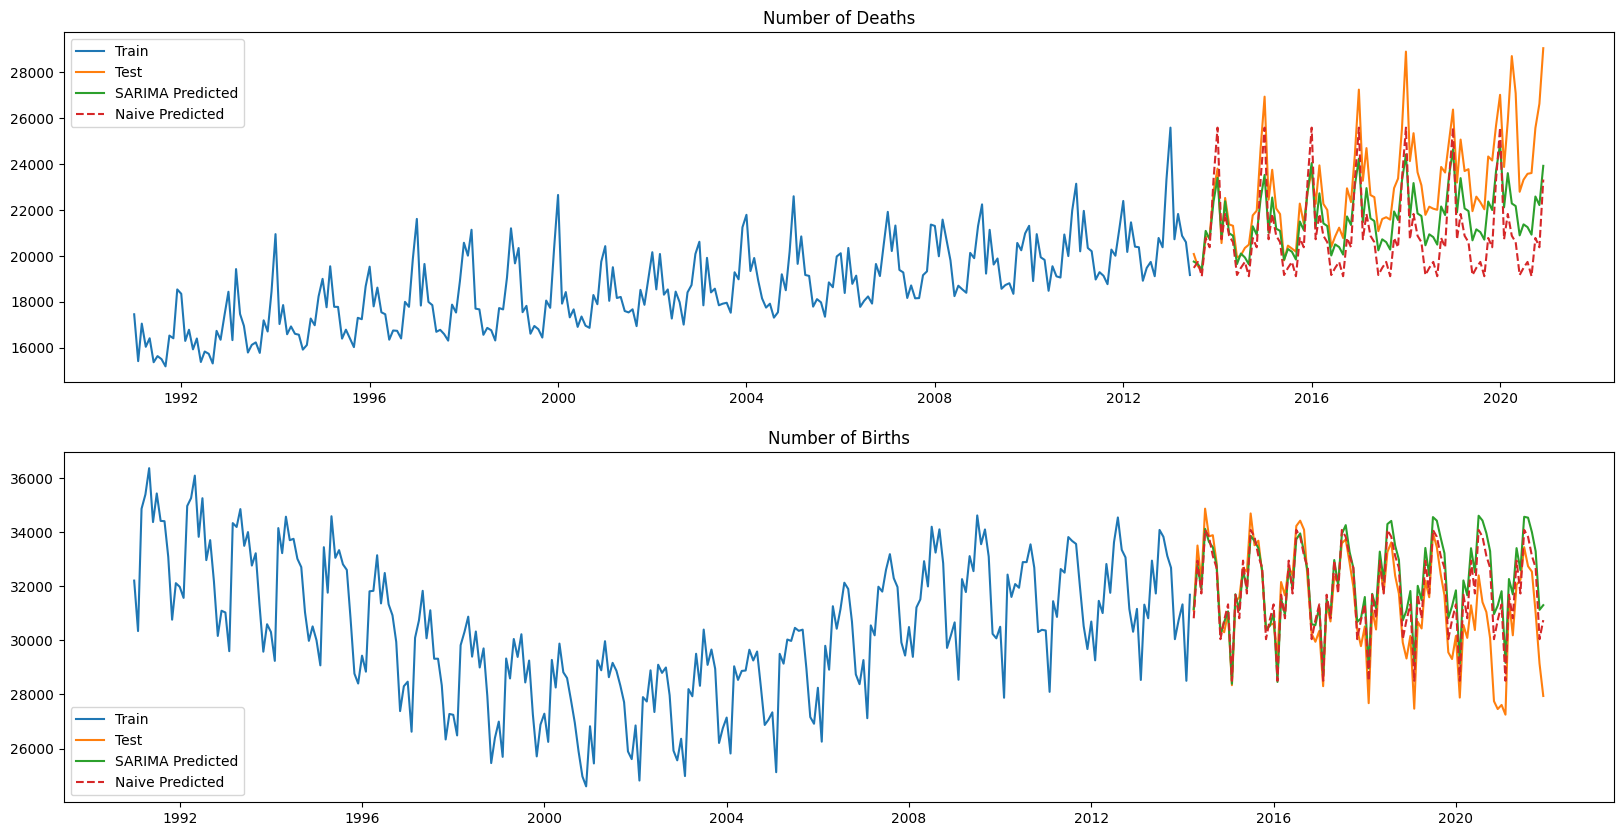

In [18]:
# Plot actual vs predicted
fig, axs = plt.subplots(2, figsize=(20,10))

# plot for deaths
axs[0].plot(train_deaths, label='Train')
axs[0].plot(test_deaths, label='Test')
axs[0].plot(forecast_deaths, label='SARIMA Predicted')
axs[0].plot(test_deaths.index, naive_deaths, label='Naive Predicted', linestyle='--')
axs[0].legend(loc='best')
axs[0].set_title('Number of Deaths')

# plot for births
axs[1].plot(train_births, label='Train')
axs[1].plot(test_births, label='Test')
axs[1].plot(forecast_births, label='SARIMA Predicted')
axs[1].plot(test_births.index, naive_births, label='Naive Predicted', linestyle='--')
axs[1].legend(loc='best')
axs[1].set_title('Number of Births')

plt.show()

19:40:13 - cmdstanpy - INFO - Chain [1] start processing
19:40:14 - cmdstanpy - INFO - Chain [1] done processing
19:40:14 - cmdstanpy - INFO - Chain [1] start processing
19:40:14 - cmdstanpy - INFO - Chain [1] done processing


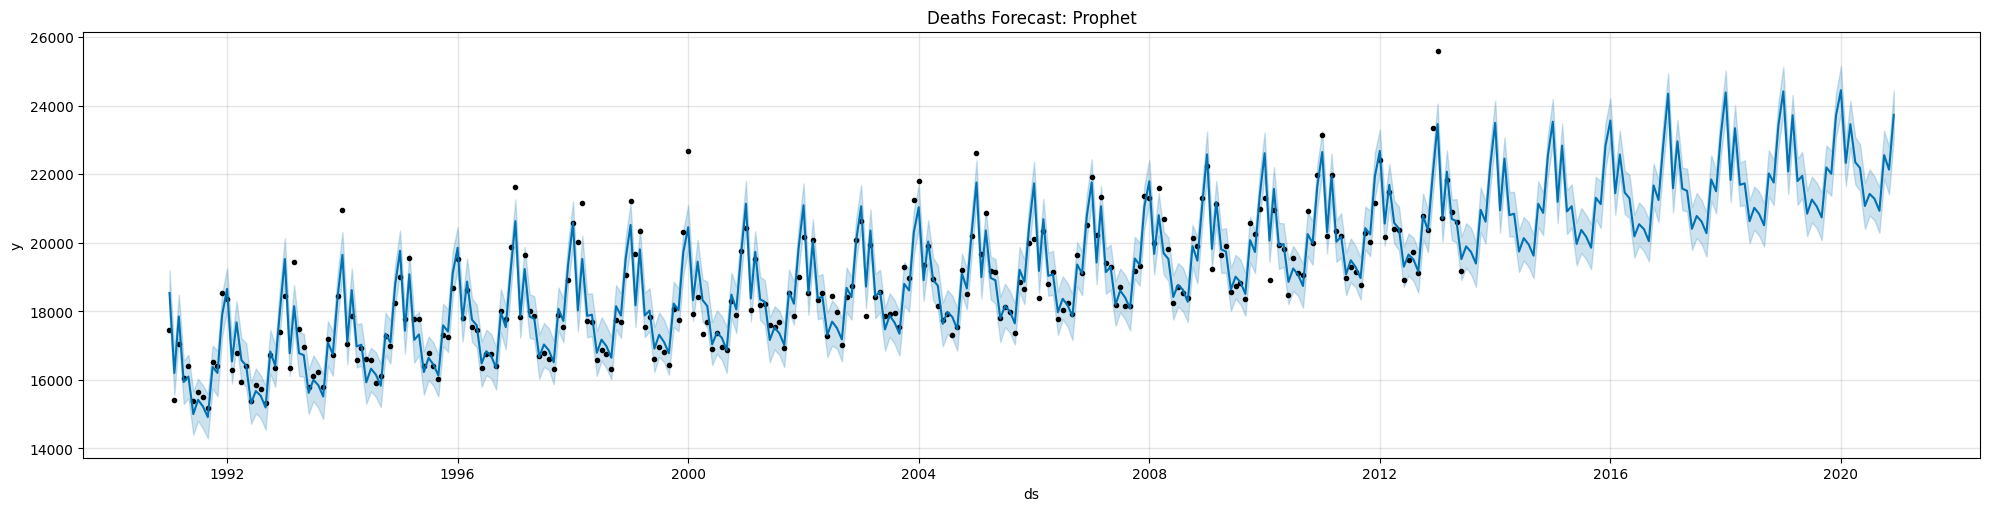

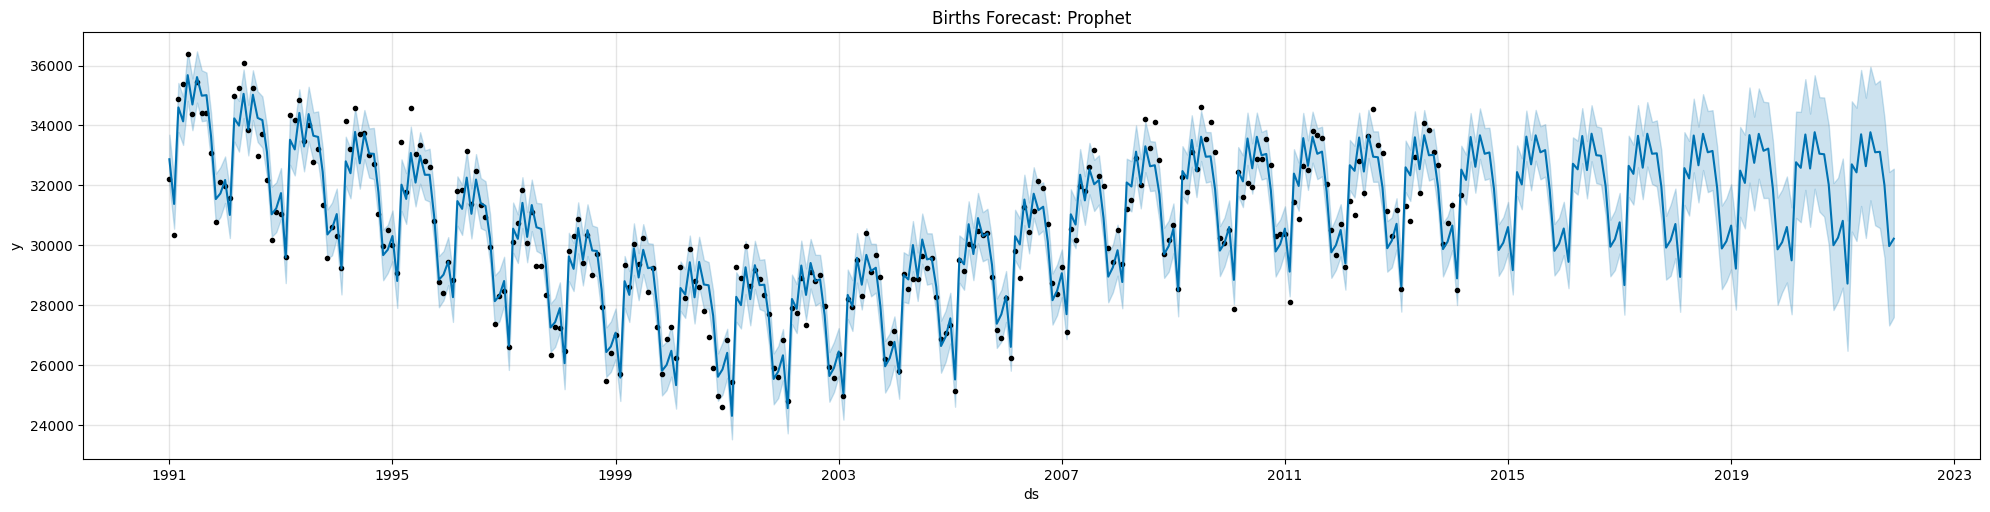

In [19]:

# Prophet requires columns ds (Date) and y (value)
deaths = train_deaths.reset_index().rename(columns={'date':'ds', 'value':'y'})
births = train_births.reset_index().rename(columns={'date':'ds', 'value':'y'})

# Make the prophet models and fit on the data 
# changepoint_prior_scale can be changed to achieve a better fit
prophet_deaths = Prophet(changepoint_prior_scale=0.05)
prophet_births = Prophet(changepoint_prior_scale=0.05)

prophet_deaths.fit(deaths)
prophet_births.fit(births)

# We need to specify the number of days to forecast
future_deaths = prophet_deaths.make_future_dataframe(periods=len(test_deaths), freq='MS')
future_births = prophet_births.make_future_dataframe(periods=len(test_births), freq='MS')

forecast_deaths = prophet_deaths.predict(future_deaths)
forecast_births = prophet_births.predict(future_births)

# Plot the prophet results
prophet_deaths.plot(forecast_deaths, figsize=(20, 5))
plt.title('Deaths Forecast: Prophet')
plt.show()

prophet_births.plot(forecast_births, figsize=(20, 5))
plt.title('Births Forecast: Prophet')
plt.show()


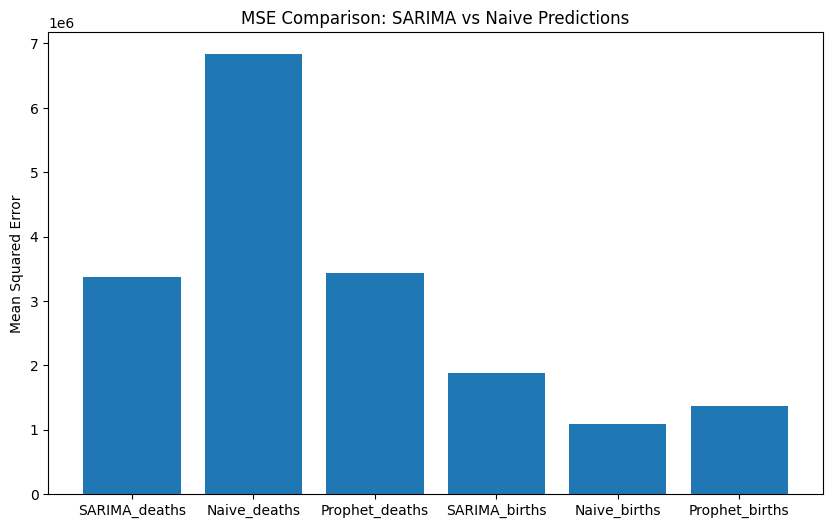

In [20]:
# Extract prophet predictions and calculate MSE
prophet_forecast_deaths = forecast_deaths.loc[len(train_deaths):, 'yhat']
prophet_forecast_births = forecast_births.loc[len(train_births):, 'yhat']

mse_prophet_deaths = mean_squared_error(test_deaths, prophet_forecast_deaths)
mse_prophet_births = mean_squared_error(test_births, prophet_forecast_births)

mse_values = [mse_sarima_deaths, mse_naive_deaths, mse_prophet_deaths, mse_sarima_births, mse_naive_births,  mse_prophet_births]
labels = ['SARIMA_deaths', 'Naive_deaths', 'Prophet_deaths', 'SARIMA_births', 'Naive_births',  'Prophet_births']

plt.figure(figsize=(10, 6))
plt.bar(labels, mse_values)
plt.ylabel('Mean Squared Error')
plt.title('MSE Comparison: SARIMA vs Naive Predictions')
plt.show()
